# Задание 5.2 - Word2Vec with Negative Sampling

В этом задании мы натренируем свои версию word vectors с negative sampling на том же небольшом датасете.

Перед запуском нужно запустить скрипт `download_data.sh`, чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset

from torchvision import transforms

import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

# We'll use Principal Component Analysis (PCA) to visualize word vectors,
# so make sure you install dependencies from requirements.txt!
from sklearn.decomposition import PCA 

%matplotlib inline

In [0]:
from google.colab import files
uploaded = files.upload()

Saving stanfordSentimentTreebank.zip to stanfordSentimentTreebank (1).zip


In [0]:
!unzip stanfordSentimentTreebank.zip

Archive:  stanfordSentimentTreebank.zip
replace stanfordSentimentTreebank/datasetSentences.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: stanfordSentimentTreebank/datasetSentences.txt  
  inflating: stanfordSentimentTreebank/datasetSplit.txt  
  inflating: stanfordSentimentTreebank/dictionary.txt  
  inflating: stanfordSentimentTreebank/original_rt_snippets.txt  
  inflating: stanfordSentimentTreebank/README.txt  
  inflating: stanfordSentimentTreebank/sentiment_labels.txt  
  inflating: stanfordSentimentTreebank/SOStr.txt  
  inflating: stanfordSentimentTreebank/STree.txt  


In [0]:
device = torch.device("cuda:0") # Let's make sure GPU is available!

In [0]:
import os
import numpy as np

class StanfordTreeBank:
    '''
    Wrapper for accessing Stanford Tree Bank Dataset
    https://nlp.stanford.edu/sentiment/treebank.html
    
    Parses dataset, gives each token and index and provides lookups
    from string token to index and back
    
    Allows to generate random context with sampling strategy described in
    word2vec paper:
    https://papers.nips.cc/paper/5021-distributed-representations-of-words-and-phrases-and-their-compositionality.pdf
    '''
    def __init__(self):
        self.index_by_token = {} # map of string -> token index
        self.token_by_index = []

        self.sentences = []

        self.token_freq = {}
        
        self.token_reject_by_index = None

    def load_dataset(self, folder):
        filename = os.path.join(folder, "datasetSentences.txt")

        with open(filename, "r", encoding="latin1") as f:
            l = f.readline() # skip the first line
            
            for l in f:
                splitted_line = l.strip().split()
                words = [w.lower() for w in splitted_line[1:]] # First one is a number
                    
                self.sentences.append(words)
                for word in words:
                    if word in self.token_freq:
                        self.token_freq[word] +=1 
                    else:
                        index = len(self.token_by_index)
                        self.token_freq[word] = 1
                        self.index_by_token[word] = index
                        self.token_by_index.append(word)
        self.compute_token_prob()
                        
    def compute_token_prob(self):
        words_count = np.array([self.token_freq[token] for token in self.token_by_index])
        words_freq = words_count / np.sum(words_count)
        
        # Following sampling strategy from word2vec paper
        self.token_reject_by_index = 1- np.sqrt(1e-5/words_freq)
    
    def check_reject(self, word):
        return np.random.rand() > self.token_reject_by_index[self.index_by_token[word]]
        
    def get_random_context(self, context_length=5):
        """
        Returns tuple of center word and list of context words
        """
        sentence_sampled = []
        while len(sentence_sampled) <= 2:
            sentence_index = np.random.randint(len(self.sentences)) 
            sentence = self.sentences[sentence_index]
            sentence_sampled = [word for word in sentence if self.check_reject(word)]
    
        center_word_index = np.random.randint(len(sentence_sampled))
        
        words_before = sentence_sampled[max(center_word_index - context_length//2,0):center_word_index]
        words_after = sentence_sampled[center_word_index+1: center_word_index+1+context_length//2]
        
        return sentence_sampled[center_word_index], words_before+words_after
    
    def num_tokens(self):
        return len(self.token_by_index)
        
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
ut ['creative', 'transporter', 'frank', 'parachutes']
romijn-stamos ['which', 'rebecca']
loves ['gently', 'communicates']
music ['hottest', 'hippest', 'strangely', 'outdated']
fine ['distinguished', 'mediocre']


# Dataset для Negative Sampling должен быть немного другим

Как и прежде, Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Здесь мы реализуем прямой проход модели сами, поэтому выдавать данные можно в удобном нам виде.
Напоминаем, что в случае negative sampling каждым сэмплом является:
- вход: слово в one-hot представлении
- выход: набор из одного целевого слова и K других случайных слов из словаря.
Вместо softmax + cross-entropy loss, сеть обучается через binary cross-entropy loss - то есть, предсказывает набор бинарных переменных, для каждой из которых функция ошибки считается независимо.

Для целевого слова бинарное предсказание должно быть позитивным, а для K случайных слов - негативным.

Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте), в каждом из них K+1 целевых слов, для только одного из которых предсказание должно быть позитивным.
Например, для K=2:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `[love: 1, any: 0, rose: 0]`
- input: `orders`, target: `[nicest: 1, fool: 0, grass: 0]`
- input: `orders`, target: `[to: 1, -: 0, the: 0]`
- input: `orders`, target: `[50-year: 1, ?: 0, door: 0]`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [0]:
num_negative_samples = 10

class Word2VecNegativeSampling(Dataset):
    '''
    PyTorch Dataset for Word2Vec with Negative Sampling.
    Accepts StanfordTreebank as data and is able to generate dataset based on
    a number of random contexts
    '''
    def __init__(self, data, num_negative_samples, num_contexts=30000):
        '''
        Initializes Word2VecNegativeSampling, but doesn't generate the samples yet
        (for that, use generate_dataset)
        Arguments:
        data - StanfordTreebank instace
        num_negative_samples - number of negative samples to generate in addition to a positive one
        num_contexts - number of random contexts to use when generating a dataset
        '''
        self.data = data
        self.num_neg_samps = num_negative_samples
        self.num_contexts = num_contexts
        self.samples = []
        
        # TODO: Implement what you need for other methods!
    
    def generate_dataset(self):
        '''
        Generates dataset samples from random contexts
        Note: there will be more samples than contexts because every context
        can generate more than one sample
        '''
        self.samples = []
        for _ in range(self.num_contexts):
            center_word, other_words = data.get_random_context(np.random.randint(10))
            one_hot_index = self.data.index_by_token[center_word]
            for word in other_words:
                sample = []
                sample.append(self.data.index_by_token[word])
                for __ in range(self.num_neg_samps):
                    negative_word, ___ = data.get_random_context(np.random.randint(2))
                    sample.append(self.data.index_by_token[negative_word])
                self.samples.append((one_hot_index, sample))
        # TODO: Implement generating the dataset
        # You should sample num_contexts contexts from the data and turn them into samples
        # Note you will have several samples from one context
        
    def __len__(self):
        '''
        Returns total number of samples
        '''
        return len(self.samples)
        # TODO: Return the number of samples

    
    def __getitem__(self, index):
        '''
        Returns i-th sample
        
        Return values:
        input_vector - index of the input word (not torch.Tensor!)
        output_indices - torch.Tensor of indices of the target words. Should be 1+num_negative_samples.
        output_target - torch.Tensor with float targets for the training. Should be the same size as output_indices
                        and have 1 for the context word and 0 everywhere else
        '''
        input_index, output_indices = self.samples[index]
        output_target = np.zeros_like(output_indices)
        output_target[0] = 1
        output_indices, output_target = shuffle(output_indices, output_target)
        return input_index, torch.Tensor(output_indices), torch.Tensor(output_target)
        
        
        # TODO: Generate tuple of 3 return arguments for i-th sample

dataset = Word2VecNegativeSampling(data, num_negative_samples, 10)
dataset.generate_dataset()
input_vector, output_indices, output_target = dataset[0]

print("Sample - input: %s, output indices: %s, output target: %s" % (int(input_vector), output_indices, output_target)) # target should be able to convert to int
assert isinstance(output_indices, torch.Tensor)
assert output_indices.shape[0] == num_negative_samples+1

assert isinstance(output_target, torch.Tensor)
assert output_target.shape[0] == num_negative_samples+1
assert torch.sum(output_target) == 1.0

Sample - input: 15129, output indices: tensor([19518.,  5102.,  1058.,   956., 16573.,  3784.,   621.,  4382.,  7818.,
         1316.,  8962.]), output target: tensor([0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])


# Создаем модель

Для нашей задачи нам придется реализовать свою собственную PyTorch модель.
Эта модель реализует свой собственный прямой проход (forward pass), который получает на вход индекс входного слова и набор индексов для выходных слов. 

Как всегда, на вход приходит не один сэмпл, а целый batch.

In [0]:
# Create the usual PyTorch structures
dataset = Word2VecNegativeSampling(data, num_negative_samples, 30000)
dataset.generate_dataset()

# As begore, we'll be training very small word vectors!
wordvec_dim = 10

class Word2VecNegativeSamples(nn.Module):
    def __init__(self, num_tokens):
        super(Word2VecNegativeSamples, self).__init__()
        self.input = nn.Linear(num_tokens, 10, bias=False)
        self.output = nn.Linear(10, num_tokens, bias=False)
        
    def forward(self, input_index_batch, output_indices_batch):
        '''
        Implements forward pass with negative sampling
        
        Arguments:
        input_index_batch - Tensor of ints, shape: (batch_size, ), indices of input words in the batch
        output_indices_batch - Tensor if ints, shape: (batch_size, num_negative_samples+1),
                                indices of the target words for every sample
                                
        Returns:
        predictions - Tensor of floats, shape: (batch_size, num_negative_samples+1)
        '''
        predictions = torch.cuda.FloatTensor([])
        for batch_index, input_index in enumerate(input_index_batch):
            result = torch.cuda.FloatTensor(output_indices_batch.shape[1])
            input_weights = self.input.weight[:, input_index]
            for index, output_index in enumerate(output_indices_batch[batch_index]):
                output_weights = self.output.weight[int(output_index)]
                result[index] = torch.dot(input_weights, output_weights)
            result = torch.reshape(result, (1, len(result)))
            predictions = torch.cat((predictions, result), 0)
        return predictions
        # TODO Implement forward pass
        # Hint: You can use for loop to go over all samples on the batch,
        # run every sample indivisually and then use
        # torch.stack or torch.cat to produce the final result
    
nn_model = Word2VecNegativeSamples(data.num_tokens())
nn_model.type(torch.cuda.FloatTensor)
nn_model.to(device)

Word2VecNegativeSamples(
  (input): Linear(in_features=19538, out_features=10, bias=False)
  (output): Linear(in_features=10, out_features=19538, bias=False)
)

In [0]:
def extract_word_vectors(model):
    '''
    Extracts word vectors from the model
    
    Returns:
    input_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    output_vectors: torch.Tensor with dimensions (num_tokens, num_dimensions)
    '''
    input_vector = model.input.weight.data.clone()
    output_vector = model.output.weight.data.clone()
    return torch.t(input_vector), output_vector
    # TODO: Implement extracting word vectors from param weights
    # return tuple of input vectors and output vectos 

untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

In [0]:
def train_neg_sample(model, dataset, train_loader, optimizer, scheduler, num_epochs):    
    '''
    Trains word2vec with negative samples on and regenerating dataset every epoch
    
    Returns:
    loss_history, train_history
    '''
    loss = nn.BCEWithLogitsLoss().type(torch.cuda.FloatTensor)
    loss_history = []
    train_history = []
    for epoch in range(num_epochs):
        model.train() # Enter train mode
        loss_accum = 0
        correct_samples = 0
        total_samples = 0
        scheduler.step()
        for i_step, (to , x, y) in enumerate(train_loader):
            to_gpu = to.to(device)
            x_gpu = x.to(device)
            y_gpu = y.to(device)
            prediction = model(to_gpu, x_gpu)
            loss_value = loss(prediction, y_gpu)
            optimizer.zero_grad()
            loss_value.backward()
            optimizer.step()
            
            _, indices = torch.max(prediction, 1)
            __, indices_y = torch.max(y_gpu, 1)
            correct_samples += torch.sum(indices == indices_y)
            total_samples += indices_y.shape[0]
            
            loss_accum += loss_value
        
        ave_loss = loss_accum / i_step
        train_accuracy = float(correct_samples) / total_samples
        loss_history.append(float(ave_loss))
        train_history.append(train_accuracy)
        dataset.generate_dataset()
        
        # TODO: Implement training using negative samples
        # You can estimate accuracy by comparing prediction values with 0.5
        # And don't forget to step the scheduler!
        
        print("Epoch %i, Average loss: %f, Train accuracy: %f" % (epoch, ave_loss, train_accuracy))
        
    return loss_history, train_history

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **0.25**.

In [27]:
# Finally, let's train the model!

# TODO: We use placeholder values for hyperparameters - you will need to find better values!
optimizer = optim.SGD(nn_model.parameters(), lr=40, weight_decay=0)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=20)
#print(list(train_loader)[0])

loss_history, train_history = train_neg_sample(nn_model, dataset, train_loader, optimizer, scheduler, 35)

Epoch 0, Average loss: 0.617711, Train accuracy: 0.094868
Epoch 1, Average loss: 0.419429, Train accuracy: 0.097836
Epoch 2, Average loss: 0.367723, Train accuracy: 0.102113
Epoch 3, Average loss: 0.350111, Train accuracy: 0.104582
Epoch 4, Average loss: 0.338725, Train accuracy: 0.114419
Epoch 5, Average loss: 0.327863, Train accuracy: 0.127867
Epoch 6, Average loss: 0.321096, Train accuracy: 0.136108
Epoch 7, Average loss: 0.315989, Train accuracy: 0.150386
Epoch 8, Average loss: 0.310580, Train accuracy: 0.169728
Epoch 9, Average loss: 0.306459, Train accuracy: 0.183126
Epoch 10, Average loss: 0.300223, Train accuracy: 0.205330
Epoch 11, Average loss: 0.296150, Train accuracy: 0.221071
Epoch 12, Average loss: 0.292392, Train accuracy: 0.236320
Epoch 13, Average loss: 0.288587, Train accuracy: 0.252900
Epoch 14, Average loss: 0.285121, Train accuracy: 0.267754
Epoch 15, Average loss: 0.280869, Train accuracy: 0.284521
Epoch 16, Average loss: 0.277330, Train accuracy: 0.300006
Epoch 1

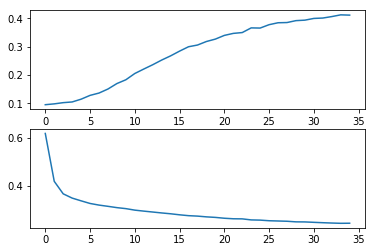

In [28]:
# Visualize training graphs
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history)

# Визуализируем вектора для разного вида слов до и после тренировки

Как и ранее, в случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных)

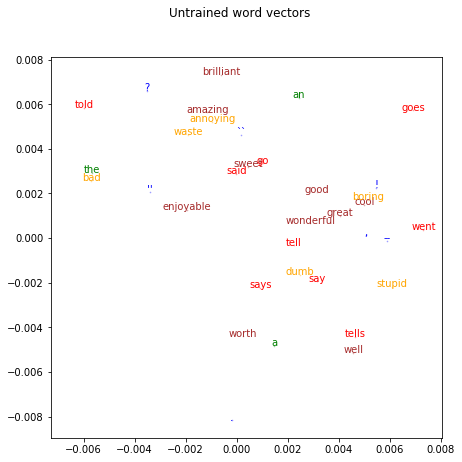

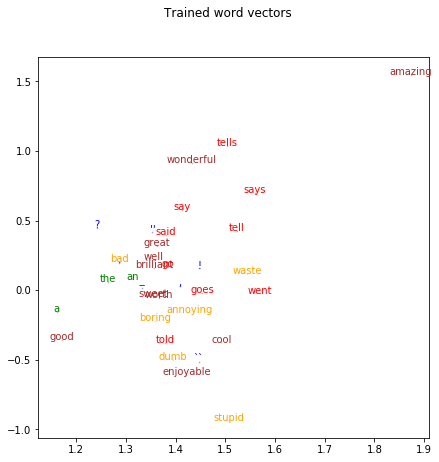

In [30]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

def visualize_vectors(input_vectors, output_vectors, title=''):
    full_vectors = torch.Tensor.cpu(torch.cat((input_vectors, output_vectors), 0))
    wordvec_embedding = PCA(n_components=2).fit_transform(full_vectors)

    # Helpful words form CS244D example
    # http://cs224d.stanford.edu/assignment1/index.html
    visualize_words = {'green': ["the", "a", "an"], 
                      'blue': [",", ".", "?", "!", "``", "''", "--"], 
                      'brown': ["good", "great", "cool", "brilliant", "wonderful", 
                              "well", "amazing", "worth", "sweet", "enjoyable"],
                      'orange': ["boring", "bad", "waste", "dumb", "annoying", "stupid"],
                      'red': ['tell', 'told', 'said', 'say', 'says', 'tells', 'goes', 'go', 'went']
                     }

    plt.figure(figsize=(7,7))
    plt.suptitle(title)
    for color, words in visualize_words.items():
        points = np.array([wordvec_embedding[data.index_by_token[w]] for w in words])
        for i, word in enumerate(words):
            plt.text(points[i, 0], points[i, 1], word, color=color,horizontalalignment='center')
        plt.scatter(points[:, 0], points[:, 1], c=color, alpha=0.3, s=0.5)

visualize_vectors(untrained_input_vectors, untrained_output_vectors, "Untrained word vectors")
visualize_vectors(trained_input_vectors, trained_output_vectors, "Trained word vectors")